In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from data import load_data
from utils import TRAINPATH, save_pickle, load_pickle, LANDMARK_DICT, DATAPATH, LANDMARKS_ANGLES_DICT, PICKLEDPATH
from plot import *
from pose import poses_for_dataset
import numpy as np
import mediapipe as mp
import pandas as pd
from tqdm import tqdm
import seaborn as sns
plt.rcParams['figure.figsize'] = [12, 8]

mp_pose = mp.solutions.pose

In [3]:
shuffle = False

# Load the data
dataset, dataloader = load_data(path=TRAINPATH, batch_size=None, shuffle=shuffle, subset=False)

In [4]:
df = load_pickle(PICKLEDPATH, "pose_landmark_all_df.pickle")
df_vis = load_pickle(PICKLEDPATH, "pose_landmark_vis_df.pickle")
numpy_data = load_pickle(PICKLEDPATH, "pose_landmark_numpy.pickle")
df_world = load_pickle(PICKLEDPATH, "pose_world_landmark_all_df.pickle")
df_vis_world = load_pickle(PICKLEDPATH, "pose_world_landmark_vis_df.pickle")
numpy_data_world = load_pickle(PICKLEDPATH, "pose_world_landmark_numpy.pickle")
labels_drop_na = load_pickle(PICKLEDPATH, "labels_drop_na.pickle")
annotated_images = load_pickle(PICKLEDPATH, "annotated_images.pickle")

In [5]:
df_world.columns

Index(['NOSE', 'LEFT_EYE_INNER', 'LEFT_EYE', 'LEFT_EYE_OUTER',
       'RIGHT_EYE_INNER', 'RIGHT_EYE', 'RIGHT_EYE_OUTER', 'LEFT_EAR',
       'RIGHT_EAR', 'MOUTH_LEFT', 'MOUTH_RIGHT', 'LEFT_SHOULDER',
       'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW', 'LEFT_WRIST',
       'RIGHT_WRIST', 'LEFT_PINKY', 'RIGHT_PINKY', 'LEFT_INDEX', 'RIGHT_INDEX',
       'LEFT_THUMB', 'RIGHT_THUMB', 'LEFT_HIP', 'RIGHT_HIP', 'LEFT_KNEE',
       'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE', 'LEFT_HEEL', 'RIGHT_HEEL',
       'LEFT_FOOT_INDEX', 'RIGHT_FOOT_INDEX', 'label', 'quality'],
      dtype='object')

In [6]:
df_world = df_world.replace(to_replace='None', value=np.nan).dropna()

In [7]:
from data import create_angle_features

create_angle_features(df_world)

In [8]:
df_world.columns

Index(['NOSE', 'LEFT_EYE_INNER', 'LEFT_EYE', 'LEFT_EYE_OUTER',
       'RIGHT_EYE_INNER', 'RIGHT_EYE', 'RIGHT_EYE_OUTER', 'LEFT_EAR',
       'RIGHT_EAR', 'MOUTH_LEFT', 'MOUTH_RIGHT', 'LEFT_SHOULDER',
       'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW', 'LEFT_WRIST',
       'RIGHT_WRIST', 'LEFT_PINKY', 'RIGHT_PINKY', 'LEFT_INDEX', 'RIGHT_INDEX',
       'LEFT_THUMB', 'RIGHT_THUMB', 'LEFT_HIP', 'RIGHT_HIP', 'LEFT_KNEE',
       'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE', 'LEFT_HEEL', 'RIGHT_HEEL',
       'LEFT_FOOT_INDEX', 'RIGHT_FOOT_INDEX', 'label', 'quality',
       'LEFT_ELBOW_ANGLE', 'RIGHT_ELBOW_ANGLE', 'LEFT_ARMPIT_ANGLE',
       'RIGHT_ARMPIT_ANGLE', 'LEFT_CHEST_ANGLE', 'RIGHT_CHEST_ANGLE',
       'LEFT_WRIST_ANGLE', 'RIGHT_WRIST_ANGLE', 'LEFT_KNEE_ANGLE',
       'RIGHT_KNEE_ANGLE', 'LEFT_HIPFLEXOR_ANGLE', 'RIGHT_HIPFLEXOR_ANGLE',
       'LEFT_ADDUCTOR_ANGLE', 'RIGHT_ADDUCTOR_ANGLE', 'LEFT_ANKLE_ANGLE',
       'RIGHT_ANKLE_ANGLE'],
      dtype='object')

## Differences Good vs. Bad for Downward Dog?

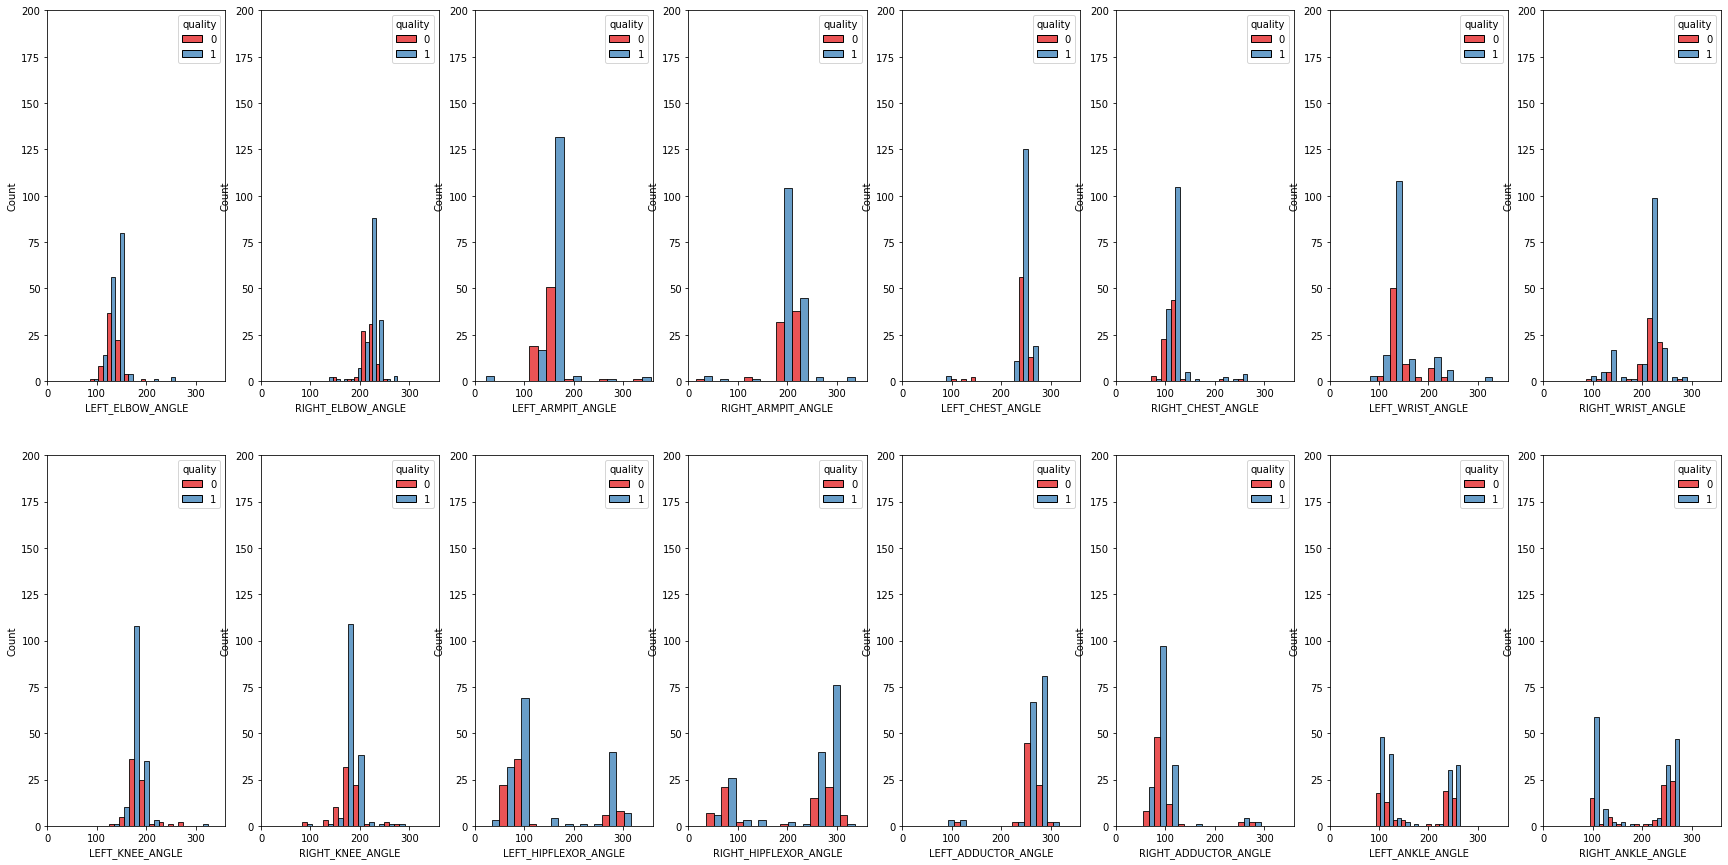

In [9]:
fig, ax = plt.subplots(2, 8, figsize=(30, 15))
sns.set_palette(sns.color_palette("Set1"))
for idx, col in enumerate(LANDMARKS_ANGLES_DICT.keys()):
    y = int(idx/8)
    x = idx % 8
    sns.histplot(df_world.loc[df_world['label']==0], x=col, hue='quality', ax=ax[y, x], bins=10, multiple='dodge')
    ax[y, x].tick_params(axis='x')
    ax[y, x].set_ylim(0,200)
    ax[y, x].set_xlim(0,360)

## Differences Good vs. Bad for Warrior I?

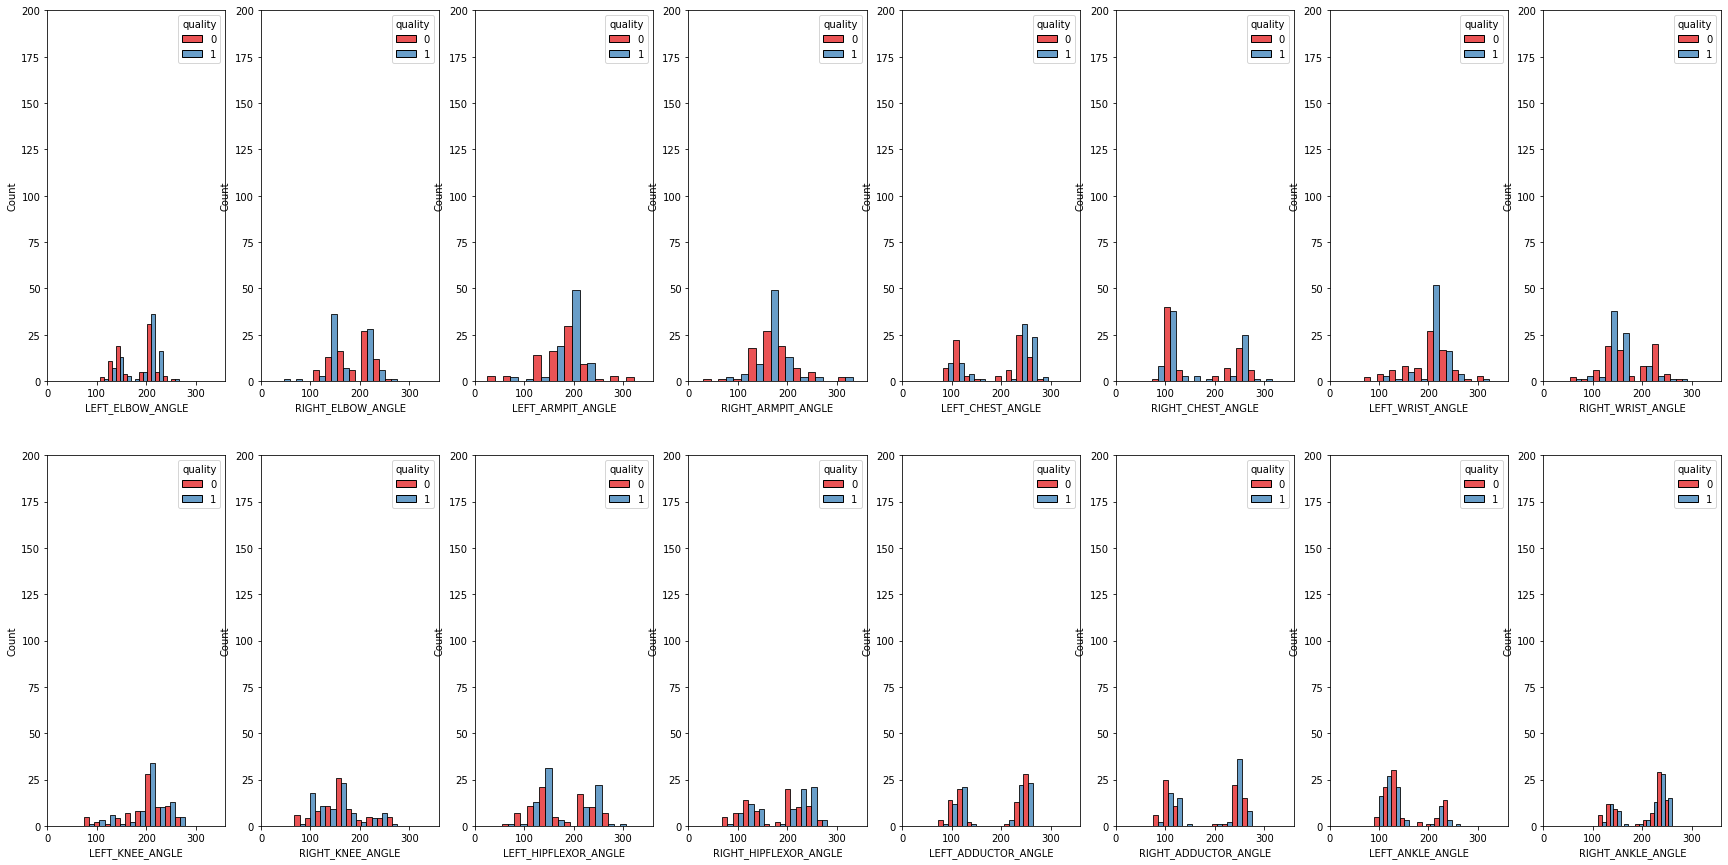

In [10]:
fig, ax = plt.subplots(2, 8, figsize=(30, 15))
sns.set_palette(sns.color_palette("Set1"))
for idx, col in enumerate(LANDMARKS_ANGLES_DICT.keys()):
    y = int(idx/8)
    x = idx % 8
    sns.histplot(df_world.loc[df_world['label']==1], x=col, hue='quality', ax=ax[y, x], bins=10, multiple='dodge')
    ax[y, x].tick_params(axis='x')
    ax[y, x].set_ylim(0,200)
    ax[y, x].set_xlim(0,360)

## Differences Good vs. Bad for Warrioir II?

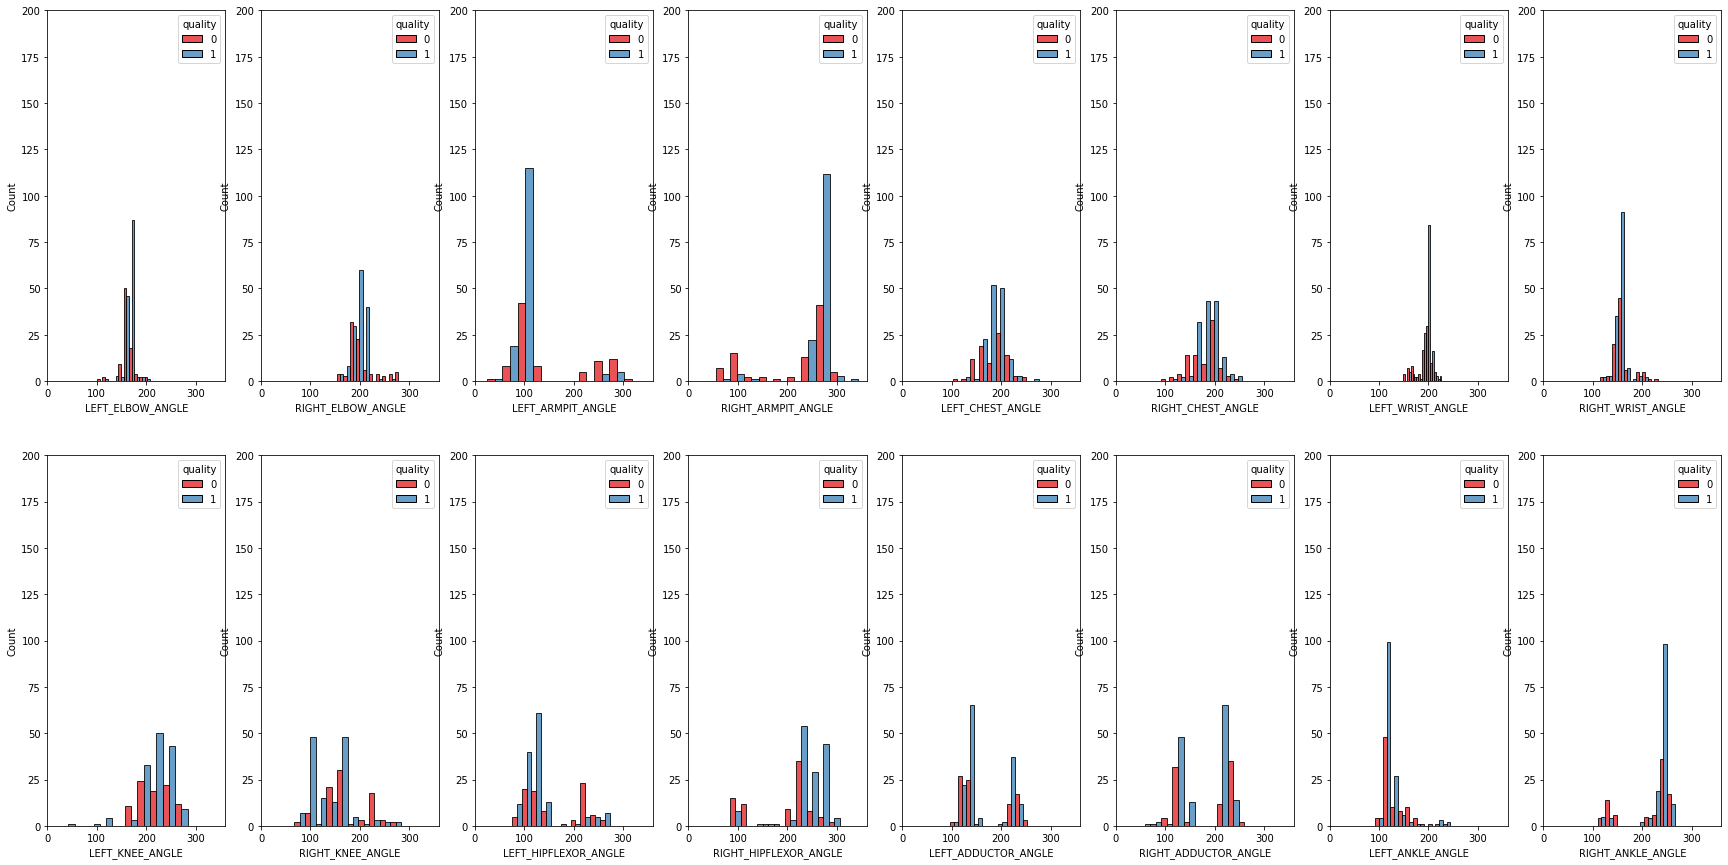

In [11]:
fig, ax = plt.subplots(2, 8, figsize=(30, 15))
sns.set_palette(sns.color_palette("Set1"))
for idx, col in enumerate(LANDMARKS_ANGLES_DICT.keys()):
    y = int(idx/8)
    x = idx % 8
    sns.histplot(df_world.loc[df_world['label']==2], x=col, hue='quality', ax=ax[y, x], bins=10, multiple='dodge')
    ax[y, x].tick_params(axis='x')
    ax[y, x].set_ylim(0,200)
    ax[y, x].set_xlim(0,360)

## Do the Decision Tree for Downward Dog

In [12]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

In [27]:
# subset to DD
df_world_dd = df_world.loc[df_world['label']==0]

In [28]:
df_world_dd_train, df_world_dd_test = train_test_split(df_world_dd, test_size=0.2, random_state=16)

In [29]:
X_train = df_world_dd_train[LANDMARKS_ANGLES_DICT]
y_train = df_world_dd_train['quality']
X_test = df_world_dd_test[LANDMARKS_ANGLES_DICT]
y_test = df_world_dd_test['quality']

In [30]:
clf = tree.DecisionTreeClassifier(max_depth=3, random_state=12)
clf = clf.fit(X_train, y_train)

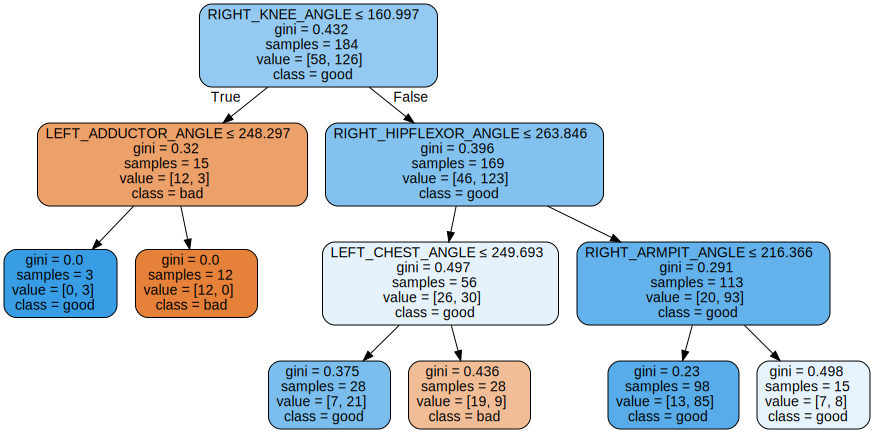

In [31]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=X_train.columns,  
                      class_names=['bad', 'good'],  
                      filled=True, rounded=True,  
                      special_characters=True)
graph = graphviz.Source(dot_data)
# graph.render('tmp')
graph

In [32]:
clf.score(X_test, y_test)

0.723404255319149

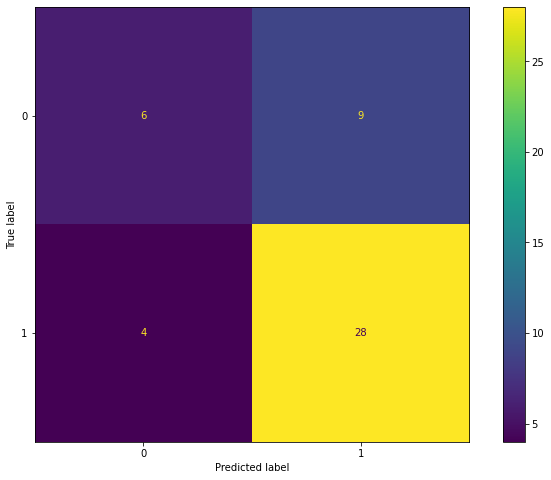

In [33]:
plot_confusion_matrix(clf, X_test, y_test)

## Do the Decision Tree for Warrior I

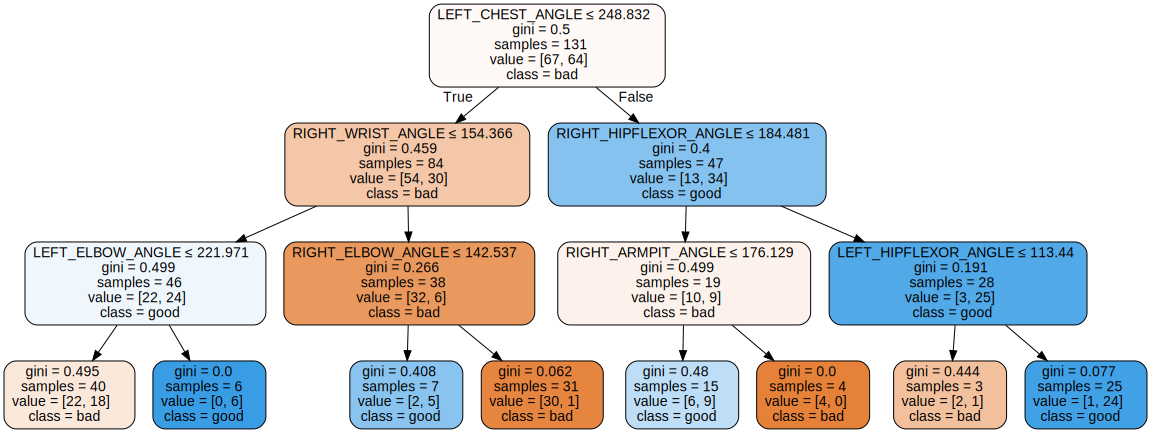

In [36]:
# subset to W1
df_world_dd = df_world.loc[df_world['label']==1]

df_world_dd_train, df_world_dd_test = train_test_split(df_world_dd, test_size=0.2, random_state=16)

X_train = df_world_dd_train[LANDMARKS_ANGLES_DICT]
y_train = df_world_dd_train['quality']
X_test = df_world_dd_test[LANDMARKS_ANGLES_DICT]
y_test = df_world_dd_test['quality']

clf = tree.DecisionTreeClassifier(max_depth=3, random_state=12)
clf = clf.fit(X_train, y_train)

dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=X_train.columns,  
                      class_names=['bad', 'good'],  
                      filled=True, rounded=True,  
                      special_characters=True)
graph = graphviz.Source(dot_data)
# graph.render('tmp')
graph

In [37]:
clf.score(X_test, y_test)

0.6363636363636364

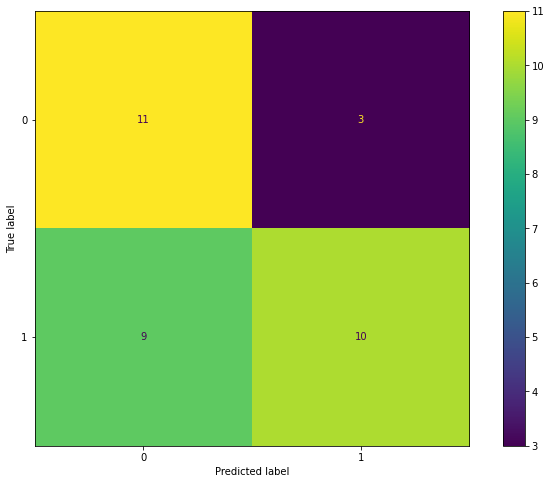

In [38]:
plot_confusion_matrix(clf, X_test, y_test)